### <center>MLZC Mid-Term project - Q4/2022<img align="right" width="60" height="60" src="../media/heart.png">

# 41 Model selection - final Training - deployment (bentoml)

<h3>Recap of tested models</h3> (ROC AUC on VAL-idation dataset):

<ul>

<li>Logistic Regression: 
<br>floAucSca = <b>0.84019</b> 
<br>(See: 21 Logistic Regression - Binary classification Optimization)

<li>Decision Tree Classifier: 
<br>floAucValDtc = <b>0.93831</b> 
<br>(See: 31 Tree)

<li>Random Forest: 
<br>floAucValRfo = <b>0.93302</b> 
<br>(See: 31 Tree)

<li><b>Xgboost</b>: 
<br>floAucValXgb = <b>0.94595</b> 
<br>(See: 31 Tree)
    
</ul>

<div class="alert alert-block alert-success">
<b>Xgboost</b> with the optimized parameters is the winner for this dataset.
<p>We will re-train it with the "Full Train", test it with the "Test" dataset and save it for deployment    
</div>

In [1]:
import pandas as pda
import numpy as npy

npy.__version__ , pda.__version__

('1.23.4', '1.5.1')

In [2]:
import pickle
from IPython.display import display

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [4]:
import xgboost as xgb

In [5]:
from pydantic import BaseModel

In [6]:
import bentoml
bentoml.__version__

'1.0.7'

In [7]:
import json

In [8]:
import requests

#### Reload data from previous notebooks

In [9]:
# use TRAin FULL dataset
strFil = '.\pickle\dstTraFul.bin'
with open(strFil, 'rb') as filIn: 
    dfrTraFul, y_TraFul = pickle.load(filIn)
dfrTraFul.shape , len(y_TraFul)

((239, 13), 239)

In [10]:
# use TRAin dataset
strFil = '.\pickle\dstTra.bin'
with open(strFil, 'rb') as filIn: 
    dfrTra, y_Tra = pickle.load(filIn)
dfrTra.shape , len(y_Tra)

((179, 12), 179)

In [11]:
# check wil VALidation dataset
strFil = '.\pickle\dstVal.bin'
with open(strFil, 'rb') as filIn: 
    dfrVal, y_Val = pickle.load(filIn)
dfrVal.shape , len(y_Val)

((60, 12), 60)

In [12]:
# use TST dataset
strFil = '.\pickle\dstTst.bin'
with open(strFil, 'rb') as filIn: 
    dfrTst, y_Tst = pickle.load(filIn)
dfrTst.shape , len(y_Tst)

((60, 12), 60)

In [13]:
strFil = '.\pickle\strTar.bin'
with open(strFil, 'rb') as filIn: 
    strTar = pickle.load(filIn)
strTar

'death_event'

In [14]:
strFil = '.\pickle\dfrFea.bin'
with open(strFil, 'rb') as filIn: 
    dfrFea = pickle.load(filIn)
dfrFea

,FeaTyp,Cor,CorAbs,Log,LogBst,LogCor,LogCorAbs,Auc
anaemia,Cat,0.040565,0.040565,NaN,NaN,NaN,NaN,0.521244
diabetes,Cat,0.030201,0.030201,NaN,NaN,NaN,NaN,0.515691
high_blood_pressure,Cat,0.053208,0.053208,NaN,NaN,NaN,NaN,0.526604
sex,Cat,0.008830,0.008830,NaN,NaN,NaN,NaN,0.504428
smoking,Cat,-0.013503,0.013503,NaN,NaN,NaN,NaN,0.506525
age,Num,0.226820,0.226820,-,-5.0,0.215981,0.215981,0.616009
creatinine_phosphokinase,Num,0.085204,0.085204,-,-32.0,0.057817,0.057817,0.526293
ejection_fraction,Num,-0.252100,0.252100,+,19.0,-0.299468,0.299468,0.663780
platelets,Num,-0.069756,0.069756,+,26.0,-0.087695,0.087695,0.544275
serum_creatinine,Num,0.312228,0.312228,+,15.0,0.359451,0.359451,0.725183


In [15]:
dfrTraFul = dfrTraFul.drop( ['death_event'] , axis=1)
dfrTraFul

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
161,45.0,1,130,0,35,0,174000.0,0.8,139,1,1,121
260,55.0,0,66,0,40,0,203000.0,1.0,138,1,0,233
218,68.0,1,1021,1,35,0,271000.0,1.1,134,1,0,197
123,60.0,1,582,0,30,1,127000.0,0.9,145,0,0,95
39,60.0,0,235,1,38,0,329000.0,3.0,142,0,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...
203,60.0,0,59,0,25,1,212000.0,3.5,136,1,1,187
255,52.0,1,191,1,30,1,334000.0,1.0,142,1,1,216
72,85.0,0,5882,0,35,0,243000.0,1.0,132,1,1,72
235,77.0,1,109,0,50,1,406000.0,1.1,137,1,0,209


### xgboost: Final

<div class="alert alert-block alert-danger">
    As in the Bentoml lesson, we will <b>remove</b> the features names:

<p>Train Before:  
<br>lstFea = dvt.get_feature_names_out().tolist()
<br>dmaTraFul = xgb.DMatrix(X_TraFul, label=y_TraFul, feature_names=lstFea)
<p>Train After:  
<br>dmaTraFul = xgb.DMatrix(X_TraFul, label=y_TraFul)
    
</div>

### Before

In [16]:
# Before

# dvt = DictVectorizer(sparse=False)
# dicTraFul = dfrTraFul.to_dict(orient='records')
# X_TraFul = dvt.fit_transform(dicTraFul)
# lstFea = dvt.get_feature_names_out().tolist()
# dmaTraFul = xgb.DMatrix(X_TraFul, label=y_TraFul, feature_names=lstFea)

# dicTst = dfrTst.to_dict(orient='records')
# X_Tst = dvt.transform(dicTst)
# dmaTst = xgb.DMatrix(X_Tst, label=y_Tst, feature_names=lstFea)

# ( dmaTraFul.num_col() , dmaTraFul.num_row() ), len(y_TraFul) , ( dmaTst.num_col() , dmaTst.num_row() ) 

In [17]:
# watchlist = [(dmaTraFul, 'train'), (dmaTst, 'val')]

# xgb_params = { 
#     'eta': 0.5, 
#     'max_depth': 2,
#     'min_child_weight': 2,
#     'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'nthread': 8, 'seed': 1, 'verbosity': 1  }

# modXgb = xgb.train(xgb_params, dmaTraFul, num_boost_round=125 ,
#                evals=watchlist , verbose_eval=125 )

### After

In [18]:
# After
dvt = DictVectorizer(sparse=False)
dicTraFul = dfrTraFul.to_dict(orient='records')
X_TraFul = dvt.fit_transform(dicTraFul)
#lstFea = dvt.get_feature_names_out().tolist()
#dmaTraFul = xgb.DMatrix(X_TraFul, label=y_TraFul, feature_names=lstFea)
dmaTraFul = xgb.DMatrix(X_TraFul, label=y_TraFul )

dicTst = dfrTst.to_dict(orient='records')
X_Tst = dvt.transform(dicTst)
#dmaTst = xgb.DMatrix(X_Tst, label=y_Tst)
dmaTst = xgb.DMatrix(X_Tst)

( dmaTraFul.num_col() , dmaTraFul.num_row() ) , ( dmaTst.num_col() , dmaTst.num_row() ) , len(y_TraFul)

((17, 239), (17, 60), 239)

In [19]:
xgb_params = { 
    'eta': 0.5, 
    'max_depth': 2,
    'min_child_weight': 2,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8, 'seed': 1, 'verbosity': 1  }

modXgb = xgb.train(xgb_params, dmaTraFul, num_boost_round=125 )

In [20]:
# Predict on TST   
y_PrdTst = modXgb.predict(dmaTst)
floAucTstXgb = roc_auc_score(y_Tst, y_PrdTst)
floAucTstXgb

0.9223602484472049

In [21]:
# Predict on Tra (curiosity) 
dicTra = dfrTra.to_dict(orient='records')
X_Tra = dvt.transform(dicTra)
dmaTra = xgb.DMatrix(X_Tra)

y_PrdTra = modXgb.predict(dmaTra)
floAucTraXgb = roc_auc_score(y_Tra, y_PrdTra)
floAucTraXgb

1.0

In [22]:
# Predict on TraFul (curiosity) 
dicTraFul = dfrTraFul.to_dict(orient='records')
X_TraFul = dvt.transform(dicTraFul)
dmaTraFul = xgb.DMatrix(X_TraFul)

y_PrdTraFul = modXgb.predict(dmaTraFul)
floAucTraFulXgb = roc_auc_score(y_TraFul, y_PrdTraFul)
floAucTraXgb

1.0

In [23]:
# Predict on Val (curiosity) 
dicVal = dfrVal.to_dict(orient='records')
X_Val = dvt.transform(dicVal)
dmaVal = xgb.DMatrix(X_Val)

y_PrdVal = modXgb.predict(dmaVal)
floAucValXgb = roc_auc_score(y_Val, y_PrdVal)
floAucValXgb

1.0

# Test Data

### Record(s) to test: dmaRec + y_Rec

In [24]:
# Some record from Train Full - start at + nbr of records
idx =23
nbr =2

dicRec = dfrTraFul[idx:idx+nbr].to_dict(orient='records')
X_Rec = dvt.transform(dicRec)
y_Rec = y_TraFul[idx:idx+nbr]
dmaRec = xgb.DMatrix(X_Rec)

In [25]:
dicRec , y_Rec

([{'age': 55.0,
   'anaemia': '0',
   'creatinine_phosphokinase': 835,
   'diabetes': '0',
   'ejection_fraction': 40,
   'high_blood_pressure': '0',
   'platelets': 279000.0,
   'serum_creatinine': 0.7,
   'serum_sodium': 140,
   'sex': '1',
   'smoking': '1',
   'time': 147},
  {'age': 45.0,
   'anaemia': '0',
   'creatinine_phosphokinase': 2442,
   'diabetes': '1',
   'ejection_fraction': 30,
   'high_blood_pressure': '0',
   'platelets': 334000.0,
   'serum_creatinine': 1.1,
   'serum_sodium': 139,
   'sex': '1',
   'smoking': '0',
   'time': 129}],
 array(['0', '1'], dtype=object))

# Build Web service

### Class to validate data 

In [26]:
class Patient(BaseModel):
    age : float
    anaemia : str
    creatinine_phosphokinase: int
    diabetes: str
    ejection_fraction: int 
    high_blood_pressure: str
    platelets: float
    serum_creatinine: float
    serum_sodium: int
    sex: str
    smoking: str
    time: int    

In [27]:
try:
    print(Patient(**dicRec[0]))
    print("*** OK ***")
except Exception as err:
    print("*** NOT OK *** Error: \n" , err)

age=55.0 anaemia='0' creatinine_phosphokinase=835 diabetes='0' ejection_fraction=40 high_blood_pressure='0' platelets=279000.0 serum_creatinine=0.7 serum_sodium=140 sex='1' smoking='1' time=147
*** OK ***


In [28]:
try:
    print(Patient(**dicRec[1]))
    print("*** OK ***")
except Exception as err:
    print("*** NOT OK *** Error: \n" , err)

age=45.0 anaemia='0' creatinine_phosphokinase=2442 diabetes='1' ejection_fraction=30 high_blood_pressure='0' platelets=334000.0 serum_creatinine=1.1 serum_sodium=139 sex='1' smoking='0' time=129
*** OK ***


In [29]:
recNok = dicRec[0].copy()
recNok['age'] = 'WTF?' # to create error
recNok['time'] = 'WTF?' # to create error
recNok

{'age': 'WTF?',
 'anaemia': '0',
 'creatinine_phosphokinase': 835,
 'diabetes': '0',
 'ejection_fraction': 40,
 'high_blood_pressure': '0',
 'platelets': 279000.0,
 'serum_creatinine': 0.7,
 'serum_sodium': 140,
 'sex': '1',
 'smoking': '1',
 'time': 'WTF?'}

In [30]:
try:
    print(Patient(**recNok))
    print("*** OK ***")
except Exception as err:
    print("*** NOT OK *** Error: \n" , str(err).replace('\n' , ' : '))

*** NOT OK *** Error: 
 2 validation errors for Patient : age :   value is not a valid float (type=type_error.float) : time :   value is not a valid integer (type=type_error.integer)


### Using parse_obj (pydantic)

In [31]:
Patient.parse_obj(dicRec[0])

Patient(age=55.0, anaemia='0', creatinine_phosphokinase=835, diabetes='0', ejection_fraction=40, high_blood_pressure='0', platelets=279000.0, serum_creatinine=0.7, serum_sodium=140, sex='1', smoking='1', time=147)

In [32]:
try:
    Patient.parse_obj(recNok)
    print("*** OK ***")
except Exception as err:
    print("*** NOT OK *** Error: \n" , str(err).replace('\n' , ': '))

*** NOT OK *** Error: 
 2 validation errors for Patient: age:   value is not a valid float (type=type_error.float): time:   value is not a valid integer (type=type_error.integer)


### save xgb model + dic vectorizer

In [33]:
modBen = bentoml.xgboost.save_model(
    'patient_death_risk',
    modXgb,
    custom_objects={
        'dictVectorizer': dvt
    })

In [34]:
modBen.info.to_dict()

{'name': 'patient_death_risk',
 'version': 'lzpccrs6akcn6nht',
 'module': 'bentoml.xgboost',
 'labels': {},
 'options': {'model_class': 'Booster'},
 'metadata': {},
 'context': {'framework_name': 'xgboost',
  'framework_versions': {'xgboost': '1.6.2'},
  'bentoml_version': '1.0.7',
  'python_version': '3.9.11'},
 'signatures': {'predict': {'batchable': False}},
 'api_version': 'v2',
 'creation_time': '2022-11-06T18:39:38.453601+00:00'}

In [35]:
modBen.path

'C:\\Users\\alain\\bentoml\\models\\patient_death_risk\\lzpccrs6akcn6nht\\'

In [36]:
modBen.custom_objects

{'dictVectorizer': DictVectorizer(sparse=False)}

In [37]:
# check files saved
!dir C:\Users\alain\bentoml\models\patient_death_risk\rcznhj22xwjg4nht\*.*

 Volume in drive C has no label.
 Volume Serial Number is E8A5-BC16

 Directory of C:\Users\alain\bentoml\models\patient_death_risk\rcznhj22xwjg4nht

02/11/2022  15:49    <DIR>          .
02/11/2022  15:49    <DIR>          ..
02/11/2022  15:49               545 custom_objects.pkl
02/11/2022  15:49               367 model.yaml
02/11/2022  15:49           108,019 saved_model.ubj
               3 File(s)        108,931 bytes
               2 Dir(s)  88,250,863,616 bytes free


In [38]:
# Chef the content of the yaml file
!type C:\Users\alain\bentoml\models\patient_death_risk\rcznhj22xwjg4nht\model.yaml

name: patient_death_risk
version: rcznhj22xwjg4nht
module: bentoml.xgboost
labels: {}
options:
  model_class: Booster
metadata: {}
context:
  framework_name: xgboost
  framework_versions:
    xgboost: 1.6.2
  bentoml_version: 1.0.7
  python_version: 3.9.11
signatures:
  predict:
    batchable: false
api_version: v2
creation_time: '2022-11-02T14:49:20.711289+00:00'


# Test Bentoml model (using booster)

In [39]:
booster = bentoml.xgboost.load_model("patient_death_risk:rcznhj22xwjg4nht")

In [40]:
booster.predict(dmaRec)

array([0.02292895, 0.92127746], dtype=float32)

### WS: patient_death_risk.py  

In [41]:
!type ..\code\patient_death_risk.py

print('***** Starting patient_death_risk.py 11.54 *****')

import numpy as npy
import bentoml
from bentoml.io import JSON
from pydantic import BaseModel

print('*** Import completed ***')

class Patient(BaseModel):
    age: float
    anaemia: str
    creatinine_phosphokinase: int
    diabetes: str
    ejection_fraction: int
    high_blood_pressure: str
    platelets: float
    serum_creatinine: float
    serum_sodium: int
    sex: str
    smoking: str
    time: int

print('*** Get model ***')
modBnt = bentoml.xgboost.get("patient_death_risk:rcznhj22xwjg4nht")
dvt = modBnt.custom_objects['dictVectorizer']

print('*** Run mmodel ***')
modBntRun = modBnt.to_runner()
svc = bentoml.Service("patient_death_risk_service", runners=[modBntRun])

@svc.api(input=JSON(), output=JSON())
# Next option will not allow error handling: better to check later pydantic model with parse_obj !
#@svc.api(input=JSON(pydantic_model=Patient), output=JSON())

async def classify(patient):
    print('\n\n*** in clas

### Launch Bentoml service
- in C:\Users\alain\Documents\prv\IT\mlzc-mid>
- > pipenv shell
- > cd code
- > bentoml serve patient_death_risk:svc --reload       
    (see https://docs.bentoml.org/en/latest/reference/cli.html#bentoml-serve)


### Test Bentoml service with 3 records (bentoml serving)

In [77]:
url = 'http://localhost:3000/classify'

In [78]:
# y = 0
dicRec[0]

{'age': 55.0,
 'anaemia': '0',
 'creatinine_phosphokinase': 835,
 'diabetes': '0',
 'ejection_fraction': 40,
 'high_blood_pressure': '0',
 'platelets': 279000.0,
 'serum_creatinine': 0.7,
 'serum_sodium': 140,
 'sex': '1',
 'smoking': '1',
 'time': 147}

In [79]:
requests.post(url, json=dicRec[0]).json()

{'prediction': [0.02292894944548607], 'interpret': 'Death NOT probable'}

In [80]:
# y = 1
dicRec[1]

{'age': 45.0,
 'anaemia': '0',
 'creatinine_phosphokinase': 2442,
 'diabetes': '1',
 'ejection_fraction': 30,
 'high_blood_pressure': '0',
 'platelets': 334000.0,
 'serum_creatinine': 1.1,
 'serum_sodium': 139,
 'sex': '1',
 'smoking': '0',
 'time': 129}

In [81]:
requests.post(url, json=dicRec[1]).json()

{'prediction': [0.9212774634361267], 'interpret': 'Death probable'}

In [82]:
# errors in json
recNok

{'age': 'WTF?',
 'anaemia': '0',
 'creatinine_phosphokinase': 835,
 'diabetes': '0',
 'ejection_fraction': 40,
 'high_blood_pressure': '0',
 'platelets': 279000.0,
 'serum_creatinine': 0.7,
 'serum_sodium': 140,
 'sex': '1',
 'smoking': '1',
 'time': 'WTF?'}

In [83]:
requests.post(url, json=recNok).json()

{'prediction': -1,
 'interpret': '2 validation errors for Patient : age :   value is not a valid float (type=type_error.float) : time :   value is not a valid integer (type=type_error.integer)'}

## Bentoml docker
- in C:\Users\alain\Documents\prv\IT\mlzc-mid>
- > pipenv shell
- > cd code 

#### bentofile.yaml

In [84]:
!type "..\code\bentofile.yaml"

# Same as `bentoml serve <service-name>`
service: "patient_death_risk:svc"  

labels:
    owner: alainD
    stage: dev

# all files to be loaded
include:
- "patient_death_risk.py"  

# all package needed
python:
    packages:  
    - xgboost
    - pandas
    - sklearn
    - pydantic


- > cd bentoml
- > bentoml build

```
(mlzc-mid-xr52rCJ4) C:\Users\alain\Documents\prv\IT\mlzc-mid\code>bentoml build
***** Starting patient_death_risk.py 11.54 *****
*** Import completed ***
*** Get model ***
*** Run mmodel ***
Building BentoML service "patient_death_risk_service:6tya6x24j62hcnht" from build context "C:\Users\alain\Documents\prv\IT\mlzc-mid\code"
Packing model "patient_death_risk:rcznhj22xwjg4nht"
Locking PyPI package versions..

██████╗░███████╗███╗░░██╗████████╗░█████╗░███╗░░░███╗██╗░░░░░
██╔══██╗██╔════╝████╗░██║╚══██╔══╝██╔══██╗████╗░████║██║░░░░░
██████╦╝█████╗░░██╔██╗██║░░░██║░░░██║░░██║██╔████╔██║██║░░░░░
██╔══██╗██╔══╝░░██║╚████║░░░██║░░░██║░░██║██║╚██╔╝██║██║░░░░░
██████╦╝███████╗██║░╚███║░░░██║░░░╚█████╔╝██║░╚═╝░██║███████╗
╚═════╝░╚══════╝╚═╝░░╚══╝░░░╚═╝░░░░╚════╝░╚═╝░░░░░╚═╝╚══════╝

Successfully built Bento(tag="patient_death_risk_service:6tya6x24j62hcnht")

(mlzc-mid-xr52rCJ4) C:\Users\alain\Documents\prv\IT\mlzc-mid\code>
```

( ! ) Docker must be running !
- > bentoml containerize patient_death_risk_service:6tya6x24j62hcnht

```
(mlzc-mid-xr52rCJ4) C:\Users\alain\Documents\prv\IT\mlzc-mid\code>bentoml containerize patient_death_risk_service:6tya6x24j62hcnht
Building docker image for Bento(tag="patient_death_risk_service:6tya6x24j62hcnht")...
Successfully built docker image for "patient_death_risk_service:6tya6x24j62hcnht" with tags "patient_death_risk_service:6tya6x24j62hcnht"
To run your newly built Bento container, pass "patient_death_risk_service:6tya6x24j62hcnht" to "docker run". For example: "docker run -it --rm -p 3000:3000 patient_death_risk_service:6tya6x24j62hcnht serve --production".
```

- > docker run -it --rm -p 3000:3000 patient_death_risk_service:6tya6x24j62hcnht serve --production

### Test Bentoml service with 3 records (docker serving)

In [42]:
url = 'http://localhost:3000/classify'

In [43]:
# y = 0
dicRec[0]

{'age': 55.0,
 'anaemia': '0',
 'creatinine_phosphokinase': 835,
 'diabetes': '0',
 'ejection_fraction': 40,
 'high_blood_pressure': '0',
 'platelets': 279000.0,
 'serum_creatinine': 0.7,
 'serum_sodium': 140,
 'sex': '1',
 'smoking': '1',
 'time': 147}

In [45]:
requests.post(url, json=dicRec[0]).json()

{'prediction': [0.02292894944548607], 'interpret': 'Death NOT probable'}

In [46]:
# y = 1
dicRec[1]

{'age': 45.0,
 'anaemia': '0',
 'creatinine_phosphokinase': 2442,
 'diabetes': '1',
 'ejection_fraction': 30,
 'high_blood_pressure': '0',
 'platelets': 334000.0,
 'serum_creatinine': 1.1,
 'serum_sodium': 139,
 'sex': '1',
 'smoking': '0',
 'time': 129}

In [47]:
requests.post(url, json=dicRec[1]).json()

{'prediction': [0.9212774634361267], 'interpret': 'Death probable'}

In [48]:
# errors in json
recNok

{'age': 'WTF?',
 'anaemia': '0',
 'creatinine_phosphokinase': 835,
 'diabetes': '0',
 'ejection_fraction': 40,
 'high_blood_pressure': '0',
 'platelets': 279000.0,
 'serum_creatinine': 0.7,
 'serum_sodium': 140,
 'sex': '1',
 'smoking': '1',
 'time': 'WTF?'}

In [49]:
requests.post(url, json=recNok).json()

{'prediction': -1,
 'interpret': '2 validation errors for Patient : age :   value is not a valid float (type=type_error.float) : time :   value is not a valid integer (type=type_error.integer)'}

### Docker desktop screen
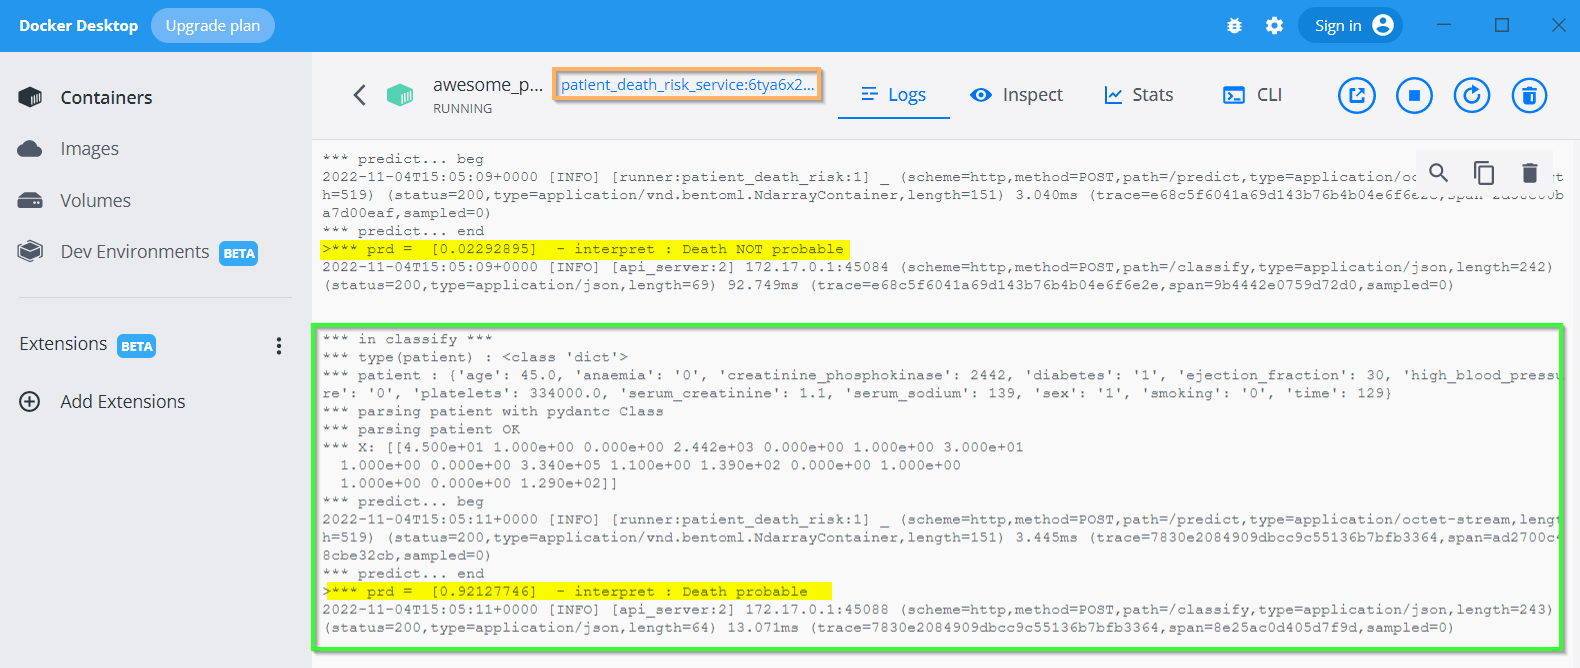